In [2]:
import os
from os import listdir
from os.path import isfile, join, dirname, basename
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib.gridspec as gridspec

In [5]:
# from analysis_utils import collect_cv_metrics, map_groups, plot_cv_metrics

In [20]:
%run analysis_utils.py

<Figure size 640x480 with 0 Axes>

In [21]:
def collect_auprc_scores(metric='AUPRC', clf='avg', base_dir='results'):
    all_results = []

    for subdir in os.listdir(base_dir):
        if subdir.startswith('__'):
            print(f'skipping {subdir}')
            continue
        exp_path = os.path.join(base_dir, subdir)
        file_path = os.path.join(exp_path, f'{metric}_{clf}.csv')
        if os.path.isfile(file_path):
            try:
                df = pd.read_csv(file_path)
                df['experiment_name'] = subdir  # Add experiment name
                all_results.append(df[['experiment_name', 'experiment', 'group', 'mean']])
            except Exception as e:
                print(f"Failed to read {file_path}: {e}")

    if not all_results:
        raise ValueError(f"No valid {metric} files found.")

    combined_df = pd.concat(all_results)
    return combined_df


In [22]:
def process_and_sort(df):
    model_means = df.groupby('experiment')['mean'].mean().reset_index(name='mean_overall')
    # model_means = df.groupby('experiment')['mean'].median().reset_index(name='mean_overall')

    model_groups = df[['experiment', 'group']].drop_duplicates()

    sorted_models = model_means.merge(model_groups, on='experiment')
    sorted_models = sorted_models.sort_values(by=['group', 'mean_overall'], ascending=[True, False])
    sorted_model_order = sorted_models['experiment'].tolist()

    heatmap_df = df.pivot(index='experiment_name', columns='experiment', values='mean')
    heatmap_df = heatmap_df[sorted_model_order]

    return heatmap_df, sorted_models

In [23]:

def plot_composite_by_group_panels(heatmap_df, sorted_models, metric, clf='avg', save_dir='.'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.gridspec as gridspec
    import numpy as np
    from os.path import join
    from matplotlib.cm import get_cmap
    from matplotlib.colors import Normalize

    sorted_models = sorted_models.round(2)
    heatmap_df = heatmap_df.round(2)

    # Calculate row-wise averages and sort
    row_avg = heatmap_df.mean(axis=1)
    heatmap_df = heatmap_df.loc[row_avg.sort_values(ascending=False).index]

    grouped = sorted_models.groupby('group')
    n_groups = len(grouped)
    palette = sns.color_palette("husl", n_groups)
    color_map = dict(zip(grouped.groups.keys(), palette))

    global_vmin = heatmap_df.min().min()
    global_vmax = heatmap_df.max().max()
    norm = Normalize(vmin=global_vmin, vmax=global_vmax)
    cmap = get_cmap('viridis')

    total_models = sum(len(group_df) for _, group_df in grouped)
    fig = plt.figure(figsize=(max(6, total_models * 0.5 + 1.5), max(6, heatmap_df.shape[0] * 0.6)))

    group_model_counts = [len(group_df) for _, group_df in grouped]

    # gs = gridspec.GridSpec(
    #     3,
    #     n_groups + 2,
    #     width_ratios=group_model_counts + [0.2, 1.0],
    #     height_ratios=[1.2, 6, 0.4],
    #     hspace=0.3,
    #     wspace=0.1
    # )

    gs = gridspec.GridSpec(
        3,
        n_groups + 2,  # +2 for row avg and colorbar
        width_ratios=group_model_counts + [1.0, 0.2],  # row avg, colorbar
        height_ratios=[1.2, 6, 0.4],
        hspace=0.3,
        wspace=0.1
    )
        
    for i, (group_name, group_df) in enumerate(grouped):
        # cbar = (i == n_groups - 1)
        # cbar_ax = fig.add_subplot(gs[1, -2]) if cbar else None

        cbar = (i == n_groups - 1)
        cbar_ax = fig.add_subplot(gs[1, -1]) if cbar else None  # now last column
        
        color = color_map[group_name]
        model_names = group_df['experiment'].tolist()
        model_avg = group_df['mean_overall'].tolist()
        group_heatmap = heatmap_df[model_names]

        # Top bar plot
        ax_top = fig.add_subplot(gs[0, i])
        bars = ax_top.bar(range(len(model_avg)), model_avg, color=color)
        ax_top.set_xticks([])
        ax_top.set_yticks([])
        # ax_top.set_title(f"{group_name}\nAvg {metric}", fontsize=6)
        ax_top.set_ylim(0.7, 1)

        # Remove all spines (bounding boxes)
        for spine in ax_top.spines.values():
            spine.set_visible(False)

        for idx, bar in enumerate(bars):
            height = bar.get_height()
            ax_top.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=6)

        # Heatmap
        ax_heatmap = fig.add_subplot(gs[1, i])
        sns.heatmap(
            group_heatmap,
            ax=ax_heatmap,
            annot=True,
            fmt=".2f",
            cmap='viridis',
            vmin=global_vmin,
            vmax=global_vmax,
            cbar=cbar,
            cbar_ax=cbar_ax,
            xticklabels=False,
            annot_kws={"size": 6}
        )
        ax_heatmap.set_xticklabels([])
        ax_heatmap.tick_params(axis='x', bottom=False)
        ax_heatmap.set_xlabel(group_name)
        if i != 0:
            ax_heatmap.set_ylabel("")
            ax_heatmap.set_yticks([])
            ax_heatmap.set_yticklabels([])

        xticklabels = model_names
        ax_heatmap.tick_params(axis='x', rotation=90, labelsize=8)
        ax_heatmap.set_ylabel('')

        # Bottom color bar
        ax_bottom = fig.add_subplot(gs[2, i])
        for j in range(len(model_names)):
            ax_bottom.add_patch(plt.Rectangle((j, 0), 1, 1, color=color))
            
        ax_bottom.set_xlim(0, len(model_names))
        ax_bottom.set_ylim(0, 1)
        ax_bottom.axis('off')
        for j, model in enumerate(model_names):
            ax_bottom.text(j + 0.5, -0.2, model, ha='right', va='top', rotation=90, fontsize=10, rotation_mode='anchor')

     # Right-side bar plot: row average
    # ax_right_bar = fig.add_subplot(gs[1, -1])
    # avg_vals = heatmap_df.mean(axis=1)
    # y_positions = np.arange(len(avg_vals))
    
    # Right-side bar plot: row average (now second-to-last column)
    ax_right_bar = fig.add_subplot(gs[1, -2])
    avg_vals = heatmap_df.mean(axis=1)
    y_positions = np.arange(len(avg_vals))
    colors = [cmap(norm(val)) for val in avg_vals]

    ax_right_bar.barh(y_positions, avg_vals.values, color=colors)

    ax_right_bar.invert_yaxis()  # Align with heatmap rows
    ax_right_bar.set_xlim(0.4, 1.0)
    ax_right_bar.set_yticks([])
    ax_right_bar.set_xticks([])
    ax_right_bar.set_xlabel(f"Avg {metric}", fontsize=5)

    for spine in ax_right_bar.spines.values():
        spine.set_visible(False)
        

    # Use heatmap order and colormap for coloring
    colors = [cmap(norm(val)) for val in avg_vals]

    bars = ax_right_bar.barh(y_positions, avg_vals.values, color=colors)
    
    if cbar_ax is not None:
        cbar_ax.tick_params(labelsize=6)  # Control colorbar tick font size here

    # Align and remove ticks
    # ax_right_bar.invert_yaxis()  # Align top-down with heatmap
    # ax_right_bar.set_xlim(0.7, 1.0)
    # ax_right_bar.set_yticks([])
    # ax_right_bar.set_xticks([])
    # ax_right_bar.set_xlabel(f"Avg {metric}", fontsize=8)

    # Remove border/spines
    for spine in ax_right_bar.spines.values():
        spine.set_visible(False)

    # Group legend (optional)
    fig.subplots_adjust(bottom=0.25)
    legend_handles = [plt.Line2D([0], [0], color=c, lw=10) for c in color_map.values()]
    # fig.legend(legend_handles, color_map.keys(), loc='lower center', ncol=n_groups)

    output_path = join(save_dir, f'{metric}_{clf}.png')
    fig.savefig(output_path, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"Grouped panel heatmap saved to {output_path}")
    return fig

In [24]:
metrics= ['AUC', 'F1', 'AUPRC', 'Recall', 'Precision', 'Accuracy']

In [25]:
clfs = ['vote', 'mil', 'avg'] #['avg', 'mil']

In [26]:
collect_auprc_scores

<function __main__.collect_auprc_scores(metric='AUPRC', clf='avg', base_dir='results')>

In [27]:
group_map = {'geneformer':'Geneformer', 'baseline': 'Baseline', 'scgpt': 'scGPT'}


In [28]:
heatmap_df

,experiment_name,experiment,group,mean
0,Treatment Naive vs Anti PD1,GF-V2,Geneformer,0.903846
1,Treatment Naive vs Anti PD1,GF-V2 [cancer],Geneformer,0.903846
2,Treatment Naive vs Anti PD1,GF-V2-Deep,Geneformer,0.902564
3,Treatment Naive vs Anti PD1,CellPLM,other,0.805128
4,Treatment Naive vs Anti PD1,GF-V1,Geneformer,0.835897
5,Treatment Naive vs Anti PD1,HVG,Baseline,0.983333
6,Treatment Naive vs Anti PD1,PCA,Baseline,0.905128
7,Treatment Naive vs Anti PD1,scFoundation,other,0.966667
8,Treatment Naive vs Anti PD1,scGPT,scGPT,0.723077
9,Treatment Naive vs Anti PD1,scGPT [cancer],scGPT,0.835897


In [29]:
heatmap_df.to_csv('test.csv')

In [30]:
metrics

['AUC', 'F1', 'AUPRC', 'Recall', 'Precision', 'Accuracy']

In [31]:
model_name_map

{'hvg': 'HVG',
 'pca': 'PCA',
 'scgpt': 'scGPT',
 'scgpt_cancer': 'scGPT [cancer]',
 'scvi': 'scVI',
 'scvi_donor_id': 'scVI',
 'scfoundation': 'scFoundation',
 'scimilarity': 'SCimilarity',
 'cellplm': 'CellPLM',
 'gf-6L-30M-i2048': 'GF-V1',
 'gf-6L-30M-i2048_continue': 'GF-V1 [continue]',
 'Geneformer-V2-104M_CLcancer': 'GF-V2 [cancer]',
 'Geneformer-V2-104M': 'GF-V2',
 'Geneformer-V2-104M_continue': 'GF-V2 [continue]',
 'Geneformer-V2-316M': 'GF-V2-Deep',
 'gf-6L-30M-i2048_finetune': 'GF-V1 [finetune]',
 'Geneformer-V2-104M_finetune': 'GF-V2 [finetune]'}

In [33]:
test_df = collect_auprc_scores(metric='AUPRC',clf='avg', base_dir='./metrics')


In [34]:
test_df

,experiment_name,experiment,group,mean
0,brca_full_pre_post,Geneformer-V2-104M,Geneformer,0.962188
1,brca_full_pre_post,Geneformer-V2-104M_CLcancer,Geneformer,0.983333
2,brca_full_pre_post,Geneformer-V2-316M,Geneformer,0.991667
3,brca_full_pre_post,cellplm,other,0.893817
4,brca_full_pre_post,gf-6L-30M-i2048,Geneformer,0.940952
5,brca_full_pre_post,hvg,Baseline,1.000000
6,brca_full_pre_post,pca,Baseline,0.978061
7,brca_full_pre_post,scfoundation,other,0.995238
8,brca_full_pre_post,scgpt,scGPT,0.875589
9,brca_full_pre_post,scgpt_cancer,scGPT,0.944921


In [32]:
for clf in clfs:
    print(clf)
    for m in metrics:
        print(m)
        heatmap_df = collect_auprc_scores(metric=m,clf=clf, base_dir='./metrics')
        idx = heatmap_df.experiment.str.contains('continue')
        heatmap_df= heatmap_df[~idx]
        idx = heatmap_df.experiment.str.contains('freez')
        heatmap_df= heatmap_df[~idx]
        
        idx = heatmap_df.experiment.str.endswith('k')
        heatmap_df= heatmap_df[~idx]
    
        idx = heatmap_df.experiment.str.endswith('all')
        heatmap_df= heatmap_df[~idx]
        
        # heatmap_df.group = heatmap_df.group.map(group_map)
        heatmap_df.experiment = heatmap_df.experiment.map(lambda x: model_name_map.get(x, x))
        heatmap_df.experiment_name = heatmap_df.experiment_name.map(experiment_name_map)
        # heatmap_df['experiment_name'] = heatmap_df.experiment
        heatmap_df_grouped, sorted_models = process_and_sort(heatmap_df)
        plot_composite_by_group_panels(heatmap_df_grouped, sorted_models, m, clf, save_dir='./plots')
        

vote
AUC


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/AUC_vote.png
F1


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/F1_vote.png
AUPRC


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/AUPRC_vote.png
Recall


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Recall_vote.png
Precision


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Precision_vote.png
Accuracy


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Accuracy_vote.png
mil
AUC


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/AUC_mil.png
F1


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/F1_mil.png
AUPRC


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/AUPRC_mil.png
Recall


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Recall_mil.png
Precision


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Precision_mil.png
Accuracy


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Accuracy_mil.png
avg
AUC


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/AUC_avg.png
F1


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/F1_avg.png
AUPRC


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/AUPRC_avg.png
Recall


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Recall_avg.png
Precision


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Precision_avg.png
Accuracy


/var/tmp/ipykernel_3444/3215541062.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


Grouped panel heatmap saved to ./plots/Accuracy_avg.png


## Try things

In [78]:
metric= 'AUC'
clf = 'vote'
heatmap_df = collect_auprc_scores(metric='AUC',clf=clf, base_dir='.')

skipping __luad22
skipping __luad2
skipping __luad1
skipping __pycache__
skipping __brca_full_pre_post
skipping __brca_full_outcome
skipping __outcomes_old
skipping __luad1_
skipping __brca_full_chemo
skipping __brca_full_subtype
skipping __outcomes
skipping __outcomes_1
skipping __luad11


In [92]:
heatmap_df

,experiment_name,experiment,group,mean
0,brca_full_pre_post,Geneformer-V2-104M,Geneformer,0.935714
1,brca_full_pre_post,Geneformer-V2-104M_CLcancer,Geneformer,0.967460
2,brca_full_pre_post,Geneformer-V2-104M_finetune,Geneformer,1.000000
3,brca_full_pre_post,Geneformer-V2-316M,Geneformer,0.946825
4,brca_full_pre_post,gf-6L-30M-i2048,Geneformer,0.799206
...,...,...,...,...
8,luad1,hvg,Baseline,0.850000
9,luad1,pca,Baseline,0.725000
10,luad1,scgpt,scGPT,0.475000
11,luad1,scgpt_cancer,scGPT,0.475000


In [93]:
idx = heatmap_df.experiment.str.contains('continue')
heatmap_df= heatmap_df[~idx]

In [94]:

idx = heatmap_df.experiment.str.contains('freez')
heatmap_df= heatmap_df[~idx]

In [95]:
heatmap_df.experiment = heatmap_df.experiment.map(lambda x: model_name_map.get(x, x))

In [96]:
heatmap_df

,experiment_name,experiment,group,mean
0,brca_full_pre_post,GF-V2,Geneformer,0.935714
1,brca_full_pre_post,GF-V2 [cancer],Geneformer,0.967460
2,brca_full_pre_post,GF-V2 [finetune],Geneformer,1.000000
3,brca_full_pre_post,GF-V2-Deep,Geneformer,0.946825
4,brca_full_pre_post,GF-V1,Geneformer,0.799206
...,...,...,...,...
8,luad1,HVG,Baseline,0.850000
9,luad1,PCA,Baseline,0.725000
10,luad1,scGPT,scGPT,0.475000
11,luad1,scGPT [cancer],scGPT,0.475000


In [97]:
# heatmap_df.experiment_name = heatmap_df.experiment_name.map(experiment_name_map)

In [98]:
heatmap_df_grouped, sorted_models = process_and_sort(heatmap_df)

In [99]:
heatmap_df_grouped

experiment,HVG,PCA,scVI,GF-V2 [finetune],GF-V2-Deep,GF-V2 [cancer],GF-V1,GF-V1 [finetune],GF-V2,scGPT [cancer],scGPT
experiment_name,,,,,,,,,,,
brca_full_chemo,0.766667,0.621429,0.504762,0.709524,0.807143,0.678571,0.740476,0.685714,0.757143,0.588095,0.626190
brca_full_outcome,0.750000,0.700000,0.800000,0.600000,0.750000,0.725000,0.750000,0.575000,0.725000,0.850000,0.750000
brca_full_pre_post,0.673016,0.966667,0.972222,1.000000,0.946825,0.967460,0.799206,1.000000,0.935714,0.988889,0.901587
brca_full_subtype,1.000000,1.000000,1.000000,0.844444,0.866667,0.888889,0.888889,0.833333,0.788889,1.000000,0.955556
luad1,0.850000,0.725000,0.525000,0.850000,0.587500,0.675000,0.675000,0.737500,0.525000,0.475000,0.475000
luad2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Grouped panel heatmap saved to ./AUC_vote.png


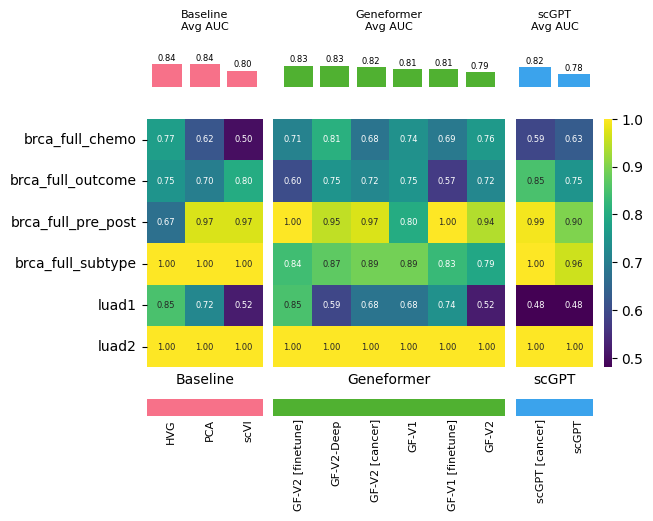

In [100]:
plot_composite_by_group_panels(heatmap_df_grouped, sorted_models, metric, clf, save_dir='.')

In [ ]:
heatmap_df

In [ ]:
# heatmap_df = process_and_sort(heatmap_df)



In [ ]:
heatmap_df

In [ ]:
# heatmap_df = heatmap_df[heatmap_df.columns.drop(list(heatmap_df.filter(regex='continue')))]

In [ ]:
heatmap_df

In [ ]:
sorted_models

In [ ]:
heatmap_df

In [ ]:
heatmap_df.round(2)

In [ ]:
def plot_composite(heatmap_df, sorted_models, output_path='auprc_heatmap_final_fixed.png'):
    import matplotlib.colors as mcolors

    model_order = sorted_models['experiment'].tolist()
    group_labels = sorted_models['group']
    model_avg = sorted_models['mean_overall'].tolist()
    n_models = len(model_order)
    x = list(range(n_models))

    fig = plt.figure(figsize=(14, max(6, heatmap_df.shape[0] * 0.5)))
    gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[3, 8, 0.4], hspace=0.2, wspace=0.05)

    # Top bar plot
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.bar(x, model_avg, color='gray')
    ax_top.set_xlim(-0.5, n_models - 0.5)
    ax_top.set_xticks(x)
    ax_top.set_xticklabels([''] * n_models)
    ax_top.set_ylabel("Avg AUPRC")
    ax_top.set_title("Average AUPRC per Model")

    # Heatmap
    ax_heatmap = fig.add_subplot(gs[1, 0])
    sns.heatmap(
        heatmap_df,
        ax=ax_heatmap,
        annot=True,
        fmt=".3f",
        cmap='viridis',
        cbar_ax=fig.add_subplot(gs[1, 1]),
        xticklabels=model_order
    )
    ax_heatmap.set_ylabel("Experiment")
    ax_heatmap.tick_params(axis='x', rotation=90, labelsize=9, pad=5)

    # Bottom group annotation bar
    ax_bottom = fig.add_subplot(gs[2, 0])
    unique_groups = group_labels.unique()
    palette = sns.color_palette("husl", len(unique_groups))
    group_color_map = dict(zip(unique_groups, palette))
    group_colors = group_labels.map(group_color_map)

    for i, color in enumerate(group_colors):
        ax_bottom.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax_bottom.set_xlim(0, n_models)
    ax_bottom.set_ylim(0, 1)
    ax_bottom.axis('off')

    # Group legend
    handles = [plt.Line2D([0], [0], color=color, lw=10) for color in group_color_map.values()]
    labels = list(group_color_map.keys())
    ax_bottom.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, -0.6))

    fig.savefig(output_path, dpi=100, bbox_inches='tight')
    plt.close()
    print(f"Final FIXED aligned heatmap saved to {output_path}")

In [ ]:

def plot_heatmap(df, output_path='auprc_heatmap.png'):
    plt.figure(figsize=(12, max(6, len(df) * 0.5)))
    sns.heatmap(df, annot=True, fmt=".3f", cmap='viridis', cbar_kws={'label': 'AUPRC'})
    plt.title("AUPRC Scores Across Experiments and Models")
    plt.ylabel("Experiment")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Heatmap saved to {output_path}")


In [ ]:
plot_composite_by_group_panels(heatmap_df, sorted_models)

In [ ]:
save_dir ='./brca_full_pre_post'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
base_dirs =['/home/jupyter/__output/brca_full/pre_post']

In [ ]:
experiments = []
for dir_ in base_dirs:
    subfolders = [ join(dir_, f.name) for f in os.scandir(dir_) if f.is_dir() ]
    experiments.extend(subfolders)

In [ ]:
results = collect_cv_metrics(experiments)
mil_df = results["mil"]
vote_df = results["vote"]
avg_df = results["avg"]


In [ ]:
mil_df['group'] = mil_df.experiment.map(map_groups)
# vote_df['group'] = vote_df.experiment.map(map_groups)
avg_df['group'] = avg_df.experiment.map(map_groups)

In [ ]:
metrics= mil_df.Metrics.unique()

In [ ]:
fig = plot_cv_metrics(mil_df,avg_df, ['MIL', 'AVG.'],'Pre vs Post',   'AUC', False, plot_type = 'bar')
